Swift-Verse

In [1]:
import numpy as np
import pandas as pd
import sys 
from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils


In [ ]:
#Load the dataset
dataset = pd.read_csv('/kaggle/input/taylor-swift-song-lyrics-from-all-the-albums/taylor_swift_lyrics.csv', encoding = "latin1")

In [ ]:
dataset.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [ ]:
dataset.lyric[2] #need to concatenate

'I said, "That\'s a lie"'

In [ ]:
def processFirstLine(lyrics, songID, songName, row):
    lyrics.append(row['lyric'] + '\n')
    songID.append( row['year']*100+ row['track_n'])
    songName.append(row['track_title'])
    return lyrics,songID,songName

In [ ]:
lyrics = []
songID = []
songName = []

# songNumber indicates the song number in the dataset
songNumber = 1
i = 0
isFirstLine = True

# Iterate through every lyrics line and join them together for each song independently 
for index,row in dataset.iterrows():
    if(songNumber == row['track_n']):
        if (isFirstLine):
            lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
            isFirstLine = False
        else :
            #if we still in the same song , keep joining the lyrics lines    
            lyrics[i] +=  row['lyric'] + '\n'
    #When it's done joining a song's lyrics lines , go to the next song :    
    else :
        lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
        songNumber = row['track_n']
        i+=1

In [ ]:
lyrics_data = pd.DataFrame({'songID':songID, 'songName':songName, 'lyrics':lyrics })

In [ ]:
lyricsText =''
for listitem in lyrics:
    lyricsText += listitem

### Preprocess

In [ ]:
#convert it to lower
raw_text = lyricsText
raw_text = raw_text.lower()


In [ ]:
# character mapping {lyrics dataset is a sequence of characters and we convert into a format that can be use
chars = sorted(list(set(raw_text)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))


In [ ]:
# Get number of chars and vocab in our text :
n_chars = len(raw_text)
n_vocab = len(chars)


In [ ]:
# making samples and labels
seq_len = 100
data_X = []
data_y = []

for i in range(0, n_chars - seq_len, 1):
    # Input Sequeance(will be used as samples)
    seq_in  = raw_text[i:i+seq_len]
    # Output sequence (will be used as target)
    seq_out = raw_text[i + seq_len]
    # Store samples in data_X
    data_X.append([chars_int[char] for char in seq_in])
    # Store targets in data_y
    data_y.append(chars_int[seq_out])
n_patterns = len(data_X)
print( 'Total Patterns : ', n_patterns)


Total Patterns :  173504


In [ ]:
# Reshape X to be suitable to go into LSTM RNN :
X = np.reshape(data_X , (n_patterns, seq_len, 1))
# Normalizing input data :
X = X/ float(n_vocab)
# One hot encode the output targets :
y = np_utils.to_categorical(data_y)

### LSTM 

In [ ]:
LSTM_layer_num = 4 # number of LSTM layers
layer_size = [256,256,256,256] # number of nodes in each layer

In [ ]:
model = Sequential()

In [ ]:
model.add(CuDNNLSTM(layer_size[0], input_shape =(X.shape[1], X.shape[2]), return_sequences = True))
for i in range(1,LSTM_layer_num) :
    model.add(CuDNNLSTM(layer_size[i], return_sequences=True))
model.add(Flatten())
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 256)          265216    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100, 256)          526336    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 100, 256)          526336    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 100, 256)          526336    
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 58)                1484858   
_________________________________________________________________
activation_1 (Activation)    (None, 58)                0         
Total para

In [ ]:
# Configure the checkpoint :
checkpoint_name = 'Weights-LSTM-improvement-{epoch:03d}-{loss:.5f}-bigger.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]

In [ ]:
# Fit the model :
model_params = {'epochs':50,
                'batch_size':128,
                'callbacks':callbacks_list,
                'verbose':1,
                'validation_split':0.2,
                'validation_data':None,
                'shuffle': True,
                'initial_epoch':0,
                'steps_per_epoch':None,
                'validation_steps':None}

model.fit(X,
          y,
          epochs = model_params['epochs'],
           batch_size = model_params['batch_size'],
           callbacks= model_params['callbacks'],
           verbose = model_params['verbose'],
           validation_split = model_params['validation_split'],
           validation_data = model_params['validation_data'],
           shuffle = model_params['shuffle'],
           initial_epoch = model_params['initial_epoch'],
           steps_per_epoch = model_params['steps_per_epoch'],
           validation_steps = model_params['validation_steps'])


In [ ]:
# Load wights file :
wights_file = '/kaggle/input/model-lstm/Weights-LSTM-improvement-043-0.05224-bigger.hdf5' # weights file path
model.load_weights(wights_file)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
# set a random seed :
start = np.random.randint(0, len(data_X)-1)
pattern = data_X[start]
print('Seed : ')
print("\"",''.join([int_chars[value] for value in pattern]), "\"\n")

# How many characters you want to generate
generated_characters = 300

# Generate Charachters :
for i in range(generated_characters):
    x = np.reshape(pattern, ( 1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x,verbose = 0)
    index = np.argmax(prediction)
    result = int_chars[index]
    #seq_in = [int_chars[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print('\nDone')


Seed : 
"  your friends
and her snotty little family
all dressed in pastel
and she is yelling at a bridesmaid
 "

somewhere back inside a room
wearing a gown shaped like a pastry
this is surely not
what you thought it would be
i lose myself in a daydream
where i stand and say
don't say yes, run away now
i'll meet you when you're out
of the church at the back door
don't wait or say a single vow
you need to hear 
Done


### RNN

<br>
Screenshots of training and output have been pasted since model was trained and tested in seperate notebook

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

In [ ]:
# Define the RNN model
model = Sequential()
model.add(SimpleRNN(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(256))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

In [ ]:
filepath="Weights-RNN-improvement-{epoch:03d}-{loss:.5f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose = 1, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]
model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)

In [ ]:
# Load wights file :
wights_file = '/kaggle/working/Weights-RNN-improvement-020-2.59000-bigger.hdf5' # weights file path
model.load_weights(wights_file)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

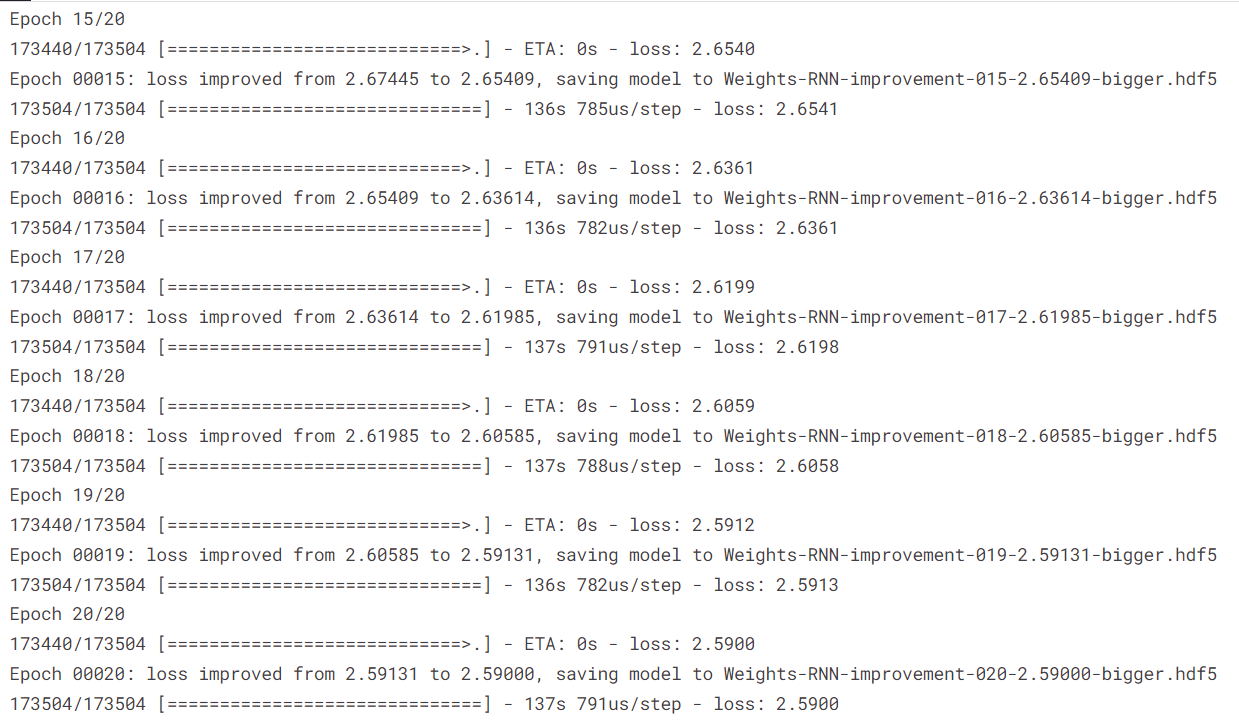

In [ ]:
# set a random seed :
start = np.random.randint(0, len(data_X)-1)
pattern = data_X[start]
print('Seed : ')
print("\"",''.join([int_chars[value] for value in pattern]), "\"\n")

# How many characters you want to generate
generated_characters = 300

# Generate Charachters :
for i in range(generated_characters):
    x = np.reshape(pattern, ( 1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x,verbose = 0)
    index = np.argmax(prediction)
    result = int_chars[index]
    #seq_in = [int_chars[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print('\nDone')

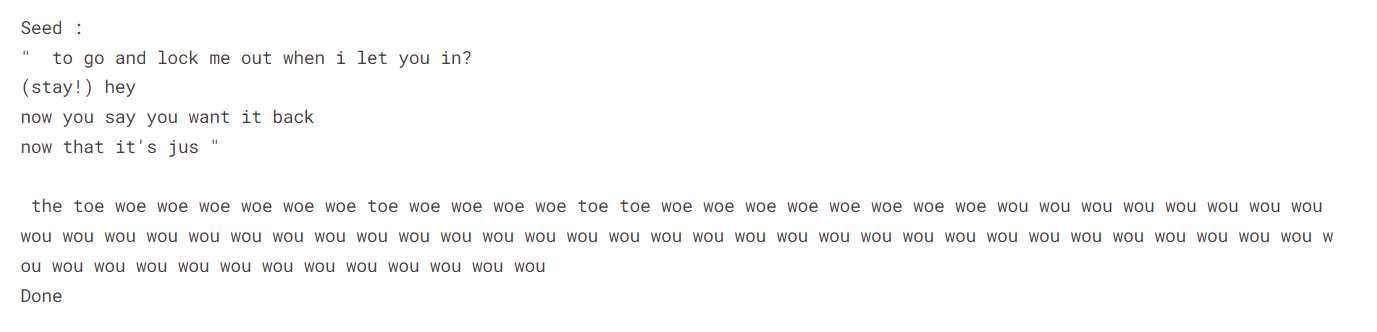